In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

import keras
import os
import sys

from PIL import Image
from pyAudioAnalysis import audioBasicIO
from pyAudioAnalysis import audioFeatureExtraction

sys.path.append('..')
import data
import model
import preprocessing
import utils

%matplotlib inline
%load_ext autoreload
%autoreload 2

Using TensorFlow backend.
C:\Users\PC\Anaconda3\envs\TensorFlow-GPU-Keras\lib\site-packages\pydub\utils.py:165: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


In [15]:
params = utils.yaml_to_dict('config.yml')

## Construir el nuevo conjunto de datos

Este dataset contiene el Espectograma de la palabra completa, osea que no se le aplica el proceso de separación por ventanas

In [13]:
def save_img(spectogram,specgram_folder,file):
    
    if not os.path.exists(specgram_folder):
        os.makedirs(specgram_folder)
      
    fpath = os.path.join(specgram_folder, file)
    im = Image.fromarray(spectogram,'L')
    im.save(fpath)

def generate_spectogram_images(params):
    
    audios_path = os.path.join(params['data_dir'],params['data_dir_audios'])
    
    for root, dirs, files in os.walk(audios_path, topdown=False):
        for name in files:
            
            specgram_folder = os.path.join(params['data_dir'],params['data_dir_images']+'_test',root.split(os.path.sep)[-1])
        
            [fs, x] = audioBasicIO.readAudioFile(os.path.join(root, name))
            x = audioBasicIO.stereo2mono(x)
            x = preprocessing._rescaled_signal(x)
            
            segments = preprocessing._find_segments_from_audio(x=x, fs=fs)
            
            for i,segment in enumerate(segments):
                
                imname = 'specgram_matrix_' + os.path.splitext(name)[0] + '_segment' + str(i) + '.jpeg'
                audio_fragment = preprocessing._extract_audio_fragments(x=x, fs=fs, segment=segment)

                specgram, TimeAxis, FreqAxis = audioFeatureExtraction.stSpectogram(
                    audio_fragment,
                    fs,
                    round(fs * 0.02),
                    round(fs * 0.01),
                    False)
            
                save_img(specgram,specgram_folder,imname)
                #preprocessing._save_specgram_as_image(specgram_folder, specgram, imname)

In [60]:
generate_spectogram_images(params)

In [17]:
params['data_dir_images'] = 'images_test'
preprocessing.split_data(params)

## Instanciar el modelo

In [4]:
inputs = tf.keras.layers.Input(shape=(224,224, 3))
net = model.ModelArchitecture(num_classes=params['num_classes'])
x = net(inputs, training=False)
net.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 112, 112, 64)      9472      
_________________________________________________________________
batch_normalization (BatchNo (None, 112, 112, 64)      256       
_________________________________________________________________
activation (Activation)      (None, 112, 112, 64)      0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 10)                650       
_________________________________________________________________
activation_1 (Activation)    (None, 10)                0         
Total params: 10,378
Trainable params: 10,250
Non-trainable params: 128
_________________________________________________________________


## Crear el generador

In [18]:
def mk_datagenerator(params):  
    
    data_path = os.path.join(params['data_dir'],params['data_dir_images'])

    datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
    
    train_generator = datagen.flow_from_directory(
        data_path,
        target_size=params['image_shape'],
        batch_size=params['batch_size'],
        class_mode='categorical')   
    
    return train_generator

In [19]:
print('Data in train')
train_generator = mk_datagenerator(params)
#print('Data in validation')
#val_generator = data.make_datagenerator(params,mode='validation')

Data in train
Found 3049 images belonging to 10 classes.


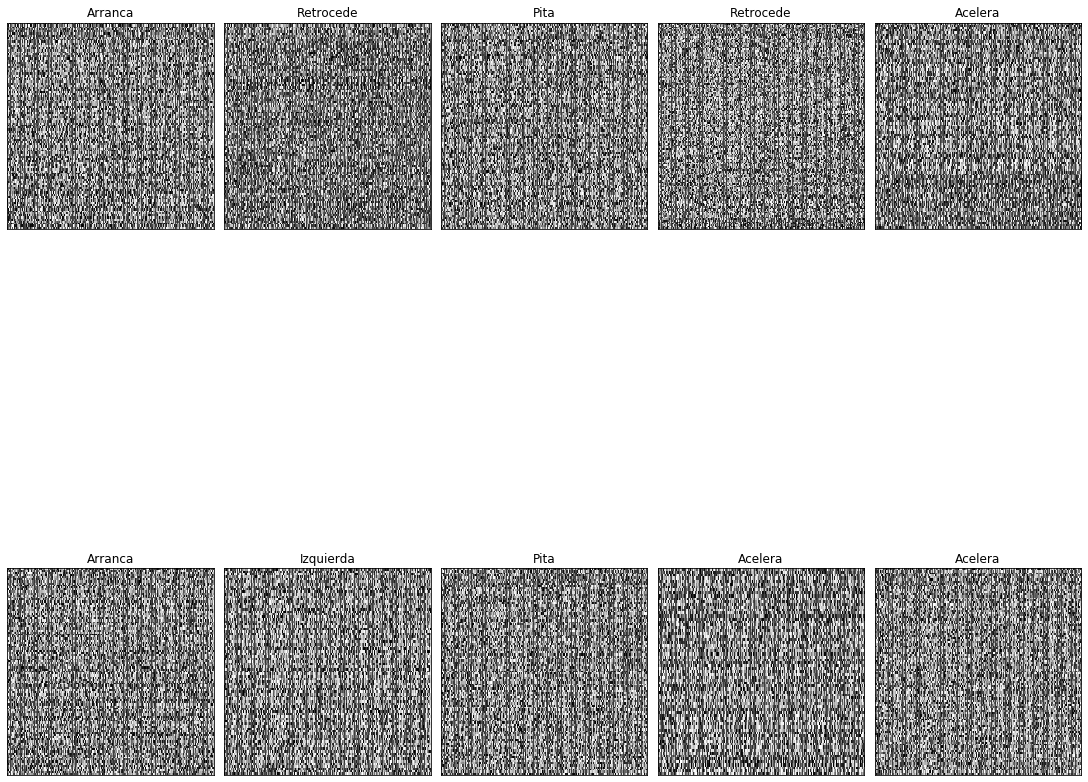

In [8]:
label_id_map = preprocessing._load_label_id_map(params)
label_map = {v:k for (k, v) in label_id_map.items()}

fig, axis = plt.subplots(2,5, figsize=(15,15), constrained_layout=True)
iteration = next(train_generator)
size = len(iteration[0])
k = 0
for i in range(2):
    for j in range(size//2):
        
        spectogram = iteration[0][k]
        label = label_map[iteration[1][k]]
    
        axis[i][j].imshow(spectogram)
        axis[i][j].title.set_text(label)

        axis[i][j].get_xaxis().set_visible(False)
        axis[i][j].get_yaxis().set_visible(False)
        
        k += 1
plt.show()

## Probar el modelo

In [21]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    os.path.join(params['model_dir'], 'tf_ckpt'), 
    save_weights_only=True, 
    verbose=1,
    period=5)

tb_callback = tf.keras.callbacks.TensorBoard(
    os.path.join(params['model_dir'], 'logs'))

optimizer = tf.keras.optimizers.Adam()

steps_per_epoch = train_generator.n // params['batch_size']
#validation_steps = val_generator.n // params['batch_size']

net.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
net.fit_generator(
    train_generator, 
    steps_per_epoch=steps_per_epoch, 
    epochs=params['num_epochs'],
    workers=4,
    #validation_data=val_generator, 
    #validation_steps=validation_steps,
    callbacks=[cp_callback, tb_callback])

Epoch 1/30
304/304 [==============================] - 22s 72ms/step - loss: 2.3046 - categorical_accuracy: 0.1089
Epoch 2/30
304/304 [==============================] - 22s 73ms/step - loss: 2.3016 - categorical_accuracy: 0.1057
Epoch 3/30
304/304 [==============================] - 22s 74ms/step - loss: 2.3009 - categorical_accuracy: 0.1112
Epoch 4/30
304/304 [==============================] - 21s 69ms/step - loss: 2.3003 - categorical_accuracy: 0.1122
Epoch 5/30
303/304 [============================>.] - ETA: 0s - loss: 2.3003 - categorical_accuracy: 0.1053
Epoch 00005: saving model to checkpoints\tf_ckpt

Consider using a TensorFlow optimizer from `tf.train`.
304/304 [==============================] - 21s 69ms/step - loss: 2.3004 - categorical_accuracy: 0.1050
Epoch 6/30
304/304 [==============================] - 22s 72ms/step - loss: 2.2993 - categorical_accuracy: 0.1155
Epoch 7/30
304/304 [==============================] - 23s 76ms/step - loss: 2.2991 - categorical_accuracy: 0.1155


Epoch 21/30
304/304 [==============================] - 25s 84ms/step - loss: 2.2988 - categorical_accuracy: 0.1158
Epoch 22/30
304/304 [==============================] - 26s 86ms/step - loss: 2.2996 - categorical_accuracy: 0.1142
Epoch 23/30
304/304 [==============================] - 27s 89ms/step - loss: 2.2992 - categorical_accuracy: 0.1135
Epoch 24/30
304/304 [==============================] - 25s 83ms/step - loss: 2.2988 - categorical_accuracy: 0.11530s - loss: 2.2988 - cate
Epoch 25/30
303/304 [============================>.] - ETA: 0s - loss: 2.2987 - categorical_accuracy: 0.1152
Epoch 00025: saving model to checkpoints\tf_ckpt

Consider using a TensorFlow optimizer from `tf.train`.
304/304 [==============================] - 25s 82ms/step - loss: 2.2988 - categorical_accuracy: 0.1148
Epoch 26/30
304/304 [==============================] - 24s 79ms/step - loss: 2.2983 - categorical_accuracy: 0.11591s - loss: 2.2985 
Epoch 27/30
304/304 [==============================] - 24s 80ms/st